In [ ]:
import csv
import os
import pickle
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder

In [ ]:
dataset_directory = "./data"

encoder = LabelEncoder()
encoder.fit(os.listdir(dataset_directory))
with open("save/encoder.pickle", "wb") as encoder_pickle:
    pickle.dump(encoder, encoder_pickle)

In [5]:
encoder.classes_

array(['classical', 'jazz', 'pop', 'rock'], dtype='<U9')

## Extract Acoustic Features

In [ ]:
from features import create_acoustic_features


headers = []
for column in "chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate".split():
    headers.append(f"{column}_mean")
    headers.append(f"{column}_var")
for i in range(1, 21):
    headers.append(f"mfcc{i}_mean")
    headers.append(f"mfcc{i}_var")
headers.append("genre")

csv_path = "save/acoustic_features.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(headers)

for genre in os.listdir(dataset_directory):
    print("extracting features of directory:", genre)
    for filename in os.listdir(f"{dataset_directory}/{genre}"):
        if not filename.endswith(".mp3"):
            continue
        for offset in (0, 10, 20):
            try:
                features = create_acoustic_features(f"{dataset_directory}/{genre}/{filename}", offset)
            except Exception:
                continue

            features.append(genre)
            with open(csv_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(features)

In [12]:
pd.read_csv("save/acoustic_features.csv").head()

,chroma_stft_mean,chroma_stft_var,rmse_mean,rmse_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
0,0.399038,0.084453,0.306986,0.007471,2377.400406,4.790446e+05,2714.741631,106728.504056,5418.573267,1.855187e+06,...,30.829190,-1.959466,35.118095,2.399588,31.725382,-4.123789,26.212091,-0.711864,24.149345,pop
1,0.385439,0.097731,0.289671,0.012891,2421.678113,1.026383e+06,2683.457690,197550.587445,5323.922099,3.801386e+06,...,90.917145,-1.193758,80.187355,-2.200609,73.361150,-4.358108,55.436314,-0.100450,89.978065,pop
2,0.346092,0.102197,0.291470,0.014296,2644.685720,1.050314e+06,2778.711943,238107.355903,5766.401945,3.841748e+06,...,125.656740,3.256760,185.753450,1.764629,155.491800,5.220235,163.361370,1.440934,130.178560,pop
3,0.366877,0.093844,0.201229,0.002637,2383.556408,6.642965e+05,2784.425415,234204.235126,5580.646842,3.816272e+06,...,63.838510,-1.549569,38.095700,-1.569264,67.947150,-2.953337,131.559070,3.741769,104.950840,pop
4,0.327308,0.089042,0.288190,0.006508,2482.256341,3.509612e+05,2740.858594,114050.991339,5749.565078,2.122776e+06,...,44.122116,3.029039,89.399650,0.354304,40.582256,-8.311977,58.993103,5.739257,74.485756,pop


## Extract Spectrograms

In [ ]:
from features import create_spectrogram

X = []
y = []

for genre in os.listdir(dataset_directory):
    print("extracting spectrograms in directory:", genre)
    genre_folder = f"{dataset_directory}/{genre}"
    for filename in os.listdir(genre_folder):
        if not filename.endswith(".mp3"):
            continue
        for offset in (0, 10, 20):
            try:
                spectrogram = create_spectrogram(f"{genre_folder}/{filename}")
            except Exception:
                continue
            X.append(spectrogram)
            y.append(genre)

X = np.array(X).reshape(-1, 128, 128, 1)
y = encoder.transform(y)

print("dumping pickles...")
with open("save/spectrograms_X.pickle", "wb") as f:
    pickle.dump(X, f)
with open("save/spectrograms_y.pickle", "wb") as f:
    pickle.dump(y, f)

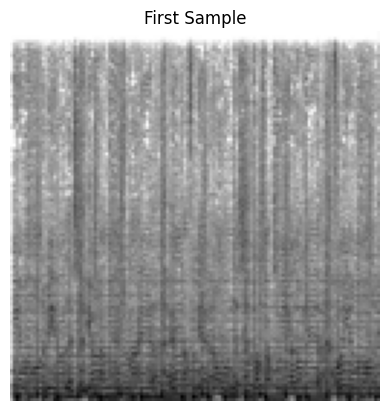

In [9]:
first_image = X[0].reshape(128, 128)

# Display it
plt.imshow(first_image, cmap='gray')
plt.title("First Sample")
plt.axis('off')
plt.show()